## Predicting Vehicle Type for Households in California

11/2/2017

Provenance of the Data: California Housing Travel Survey

## Table of Contents

### [0. Imported Modules](#Imported-Modules)
### [1. Load Data](#Load-Data)
### [1.5. Join Data](#Join-Data)
### [2. Predicting Vehicle Type](#Predicting-Vehicle-Type)
### [3. Transform and Preprocess Data](#Transform-and-Preprocess-Data)
### [4. Descriptive Statistics](#Descriptive-Statistics)
### [5. Build Preprocessed Dataset](#Build-Preprocessed-Dataset)
### [6. Feature Extraction](#Feature-Extraction)
### [7. Build Features](#Build-Features)
### [8. Baseline Models](#Baseline-Models)
### [9. Error Analysis](#Error-Analysis)
### [10. Change the Baseline](#Change-the-Baseline)
### [11. Decision Trees](#Decision-Trees)
### [12. Ensemble Methods](#Ensemble-Methods)
### [13. Summary](#Summary)

### Imported Modules
[Top](#Table-of-Contents)

In [171]:
# Tables, Queries, and Stats
import pandas as pd
import numpy as np

# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2

# Pipeline
from sklearn.pipeline import Pipeline

# Plotting
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sbn

# Data Partitioning
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

# Decision Tree Model and Plotting
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

# Ensemble Methods
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

# Error Analysis
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Computational Performance
import time

# OS, path, system access
import os
import os.path

### Load Data
[Top](#Table-of-Contents)

### There are 9 different Survey Tables in the CHTS

In [172]:
def get_tables_in(data_dir):
    tables_caltrans = [files for root, dirs, files in os.walk(os.getcwd() +\
                                                    data_dir, topdown=True, followlinks=False)][0]
    return tables_caltrans

In [173]:
caltrans_tables = get_tables_in('/caltrans_full_survey/')

In [174]:
def make_dfs_from_files(file_list, table_type, data_dir='caltrans_full_survey/'):
    ''' Create Pandas DataFrames from the list of data files in CHTS. The 
    table_type signifies the group that the data belongs to.
    Possible groups: Surveys, Vehicles, Wearables
    '''
    start = time.time()
    subset_tables = {}
    if table_type == 'survey tables':
        subset = [file for file in file_list if file.startswith('survey_')]
    if table_type == 'vehicle tables':
        subset = [file for file in file_list if file.startswith('v_')]
    if table_type == 'wearable tables':
        subset = [file for file in file_list if file.startswith('w_')]
    for file in subset:
        df = pd.read_csv(data_dir + file, low_memory=False)
        subset_tables[file] = df
    end = time.time()
    print('Loading the {} took {:.3f} seconds.'.format(table_type, end - start))
    return subset_tables

In [175]:
survey_tables = make_dfs_from_files(caltrans_tables, table_type='survey tables')
vehicle_tables = make_dfs_from_files(caltrans_tables, table_type='vehicle tables')
wearable_tables = make_dfs_from_files(caltrans_tables, table_type='wearable tables')

Loading the survey tables took 2.127 seconds.
Loading the vehicle tables took 0.107 seconds.
Loading the wearable tables took 1.605 seconds.


### From the caltrans_data_dictionary, I know the following tables have veh_type defined:
 - survey_vehicles
 - v_obd_vehicles
 - gps_obd_vehicles

#### Survey of Households, Survey Tables, California Travel Housing Survey

I will begin the exploration with survey of households and survey of vehicles

In [176]:
survey_tables.keys()

dict_keys(['survey_households.csv', 'survey_households_wgts.csv', 'survey_longtrips.csv', 'survey_longtrips_v02.csv', 'survey_person_wgts.csv', 'survey_vehicles.csv'])

In [177]:
df_survey_households = survey_tables['survey_households.csv']

In [178]:
df_survey_vehicles = survey_tables['survey_vehicles.csv']

### Null Counts in the data

**Survey of Households**

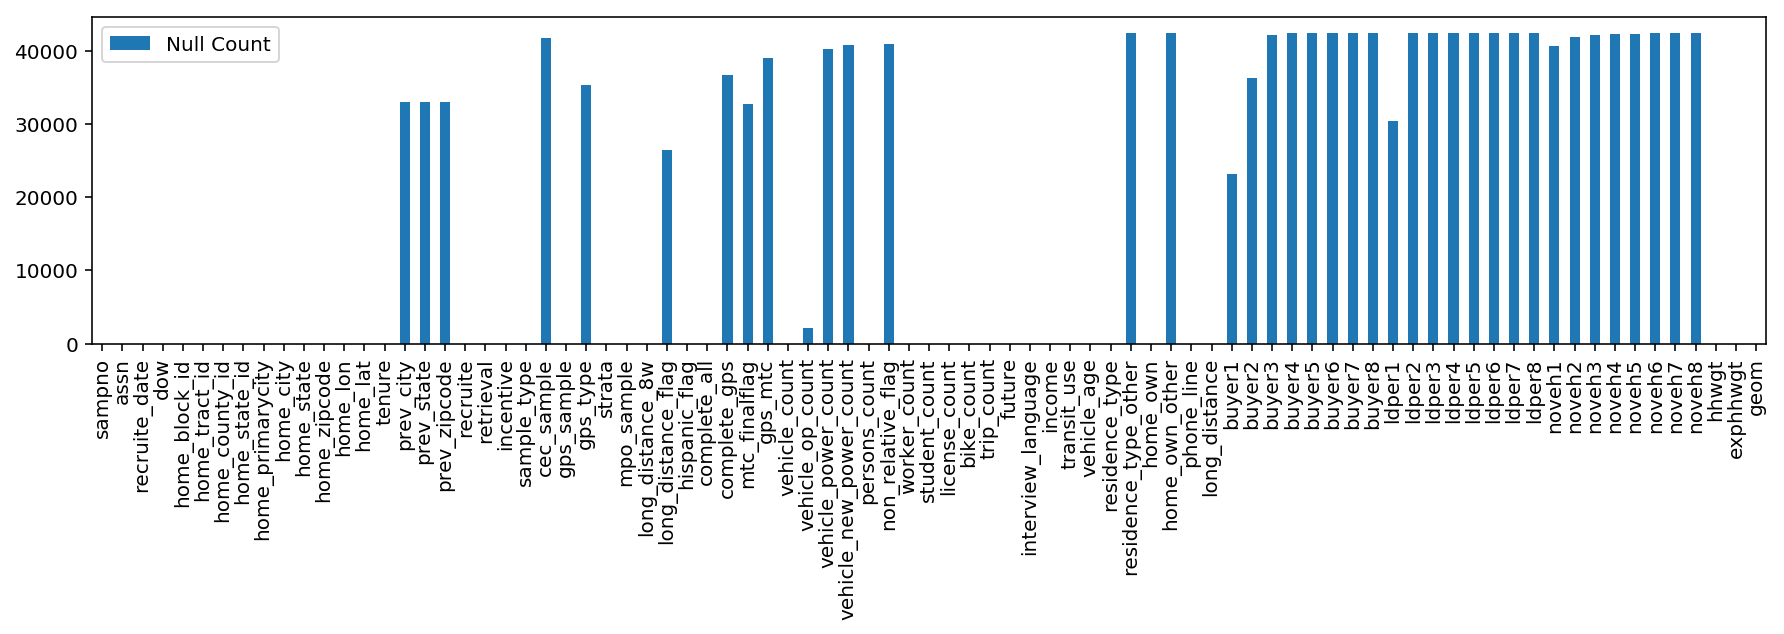

In [179]:
pd.DataFrame(df_survey_households.isnull().sum(), columns=['Null Count']).plot(kind='bar', figsize=(15,3));

**Survey of Vehicles**

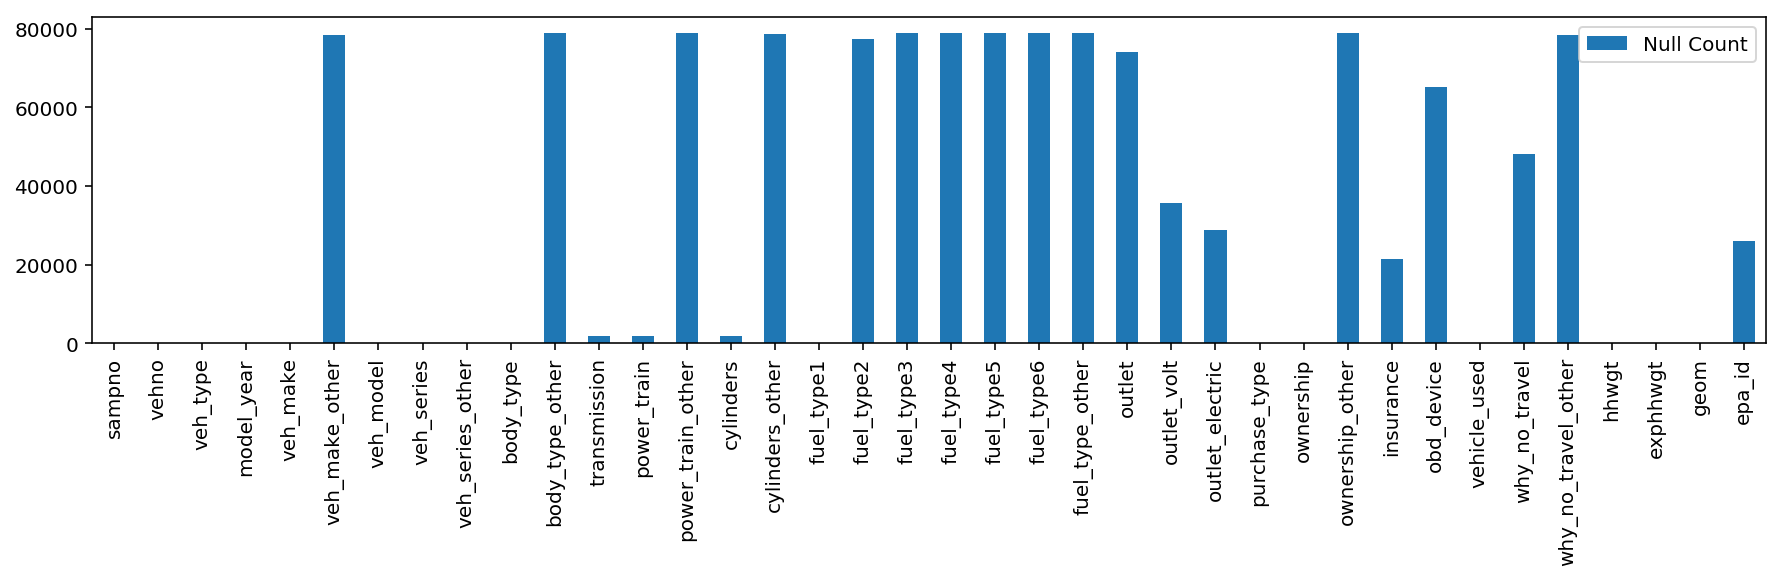

In [180]:
pd.DataFrame(df_survey_vehicles.isnull().sum(), columns=['Null Count']).plot(kind='bar', figsize=(15,3));

In [181]:
df_survey_households.shape

(42426, 83)

In [182]:
df_survey_vehicles.shape

(79011, 38)

### Join Data
[Top](#Table-of-Contents)

#### I will join two tables below, first checking for duplicate household numbers

In [183]:
len(df_survey_households['sampno'].unique()) == len(df_survey_households['sampno'])

True

So there are no duplicate entries in the households table.

In [184]:
len(df_survey_vehicles['sampno'].unique()) == len(df_survey_vehicles['sampno'])

False

In [185]:
len(df_survey_vehicles['sampno'].unique())

39973

In [186]:
sur_veh_sampno_dups = len(df_survey_vehicles['sampno']) - len(df_survey_vehicles['sampno'].unique())
sur_veh_sampno_dups

39038

Thus, there are 39,038 duplicate household entries out of the 79,011 entries for the survey_vehicles table. 

**I will do a left join and keep the extra entries for now**

In [187]:
df_survey_hous_veh = pd.merge(df_survey_vehicles, df_survey_households, on='sampno', how='left')

In [188]:
df_survey_hous_veh.shape

(79011, 120)

In [189]:
len(df_survey_hous_veh['sampno'].unique())

39973

This is the same value as before, so the merge was successful.

In [190]:
df_survey_hous_veh.head()

,sampno,vehno,veh_type,model_year,veh_make,veh_make_other,veh_model,veh_series,veh_series_other,body_type,...,noveh2,noveh3,noveh4,noveh5,noveh6,noveh7,noveh8,hhwgt_y,exphhwgt_y,geom_y
0,7156986,2,2,2009,51,NaN,REDACTED,REDACTED,REDACTED,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.304210,675.182099,REDACTED
1,7156986,3,2,2000,17,NaN,REDACTED,REDACTED,REDACTED,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.304210,675.182099,REDACTED
2,7157693,1,2,2012,20,NaN,REDACTED,REDACTED,REDACTED,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.606680,177.770223,REDACTED
3,7158808,1,2,2003,13,NaN,REDACTED,REDACTED,REDACTED,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.923009,270.461039,REDACTED
4,7158808,2,2,1992,13,NaN,REDACTED,REDACTED,REDACTED,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.923009,270.461039,REDACTED


The duplicates in the vehicles table make sense now because each household may have more than one car. This is the case with sampno=7156986.

### Null values in the joined dataset

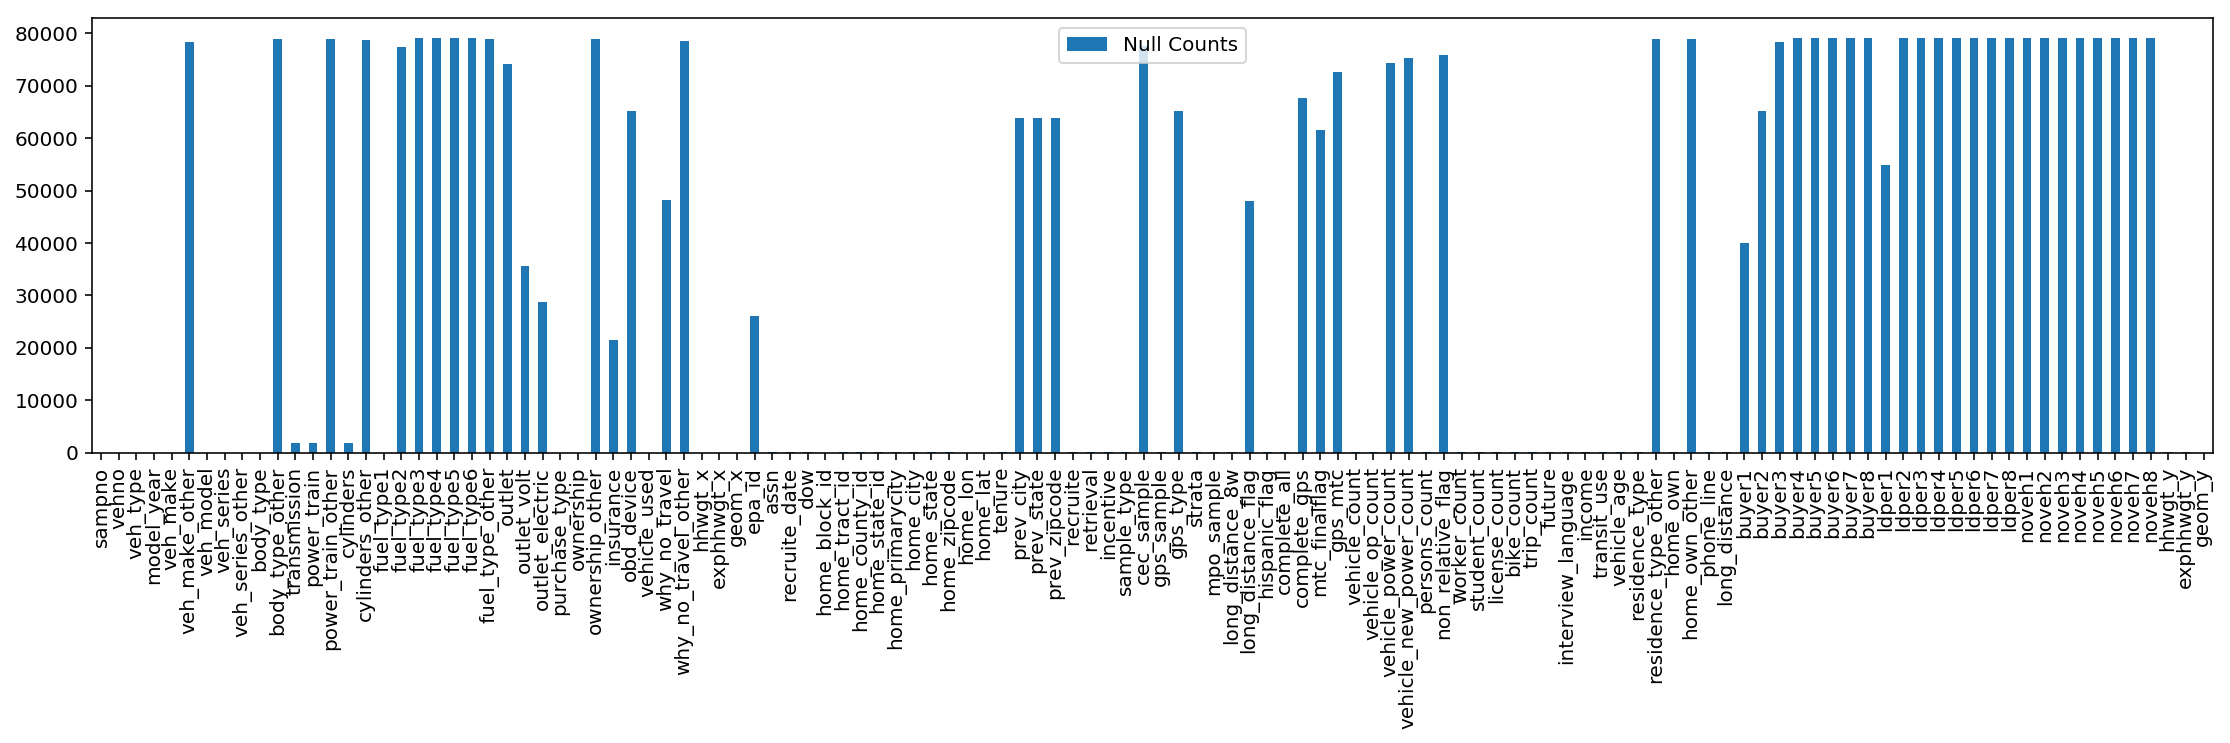

In [191]:
pd.DataFrame(df_survey_hous_veh.isnull().sum(), columns=['Null Counts']).plot(kind='bar', figsize=(19,4));

### Predicting Vehicle Type
[Top](#Table-of-Contents)

**_ We want to predict vehicle type in order to find the relationship between demographic data and vehicle preference. Our demographic data includes: Education, gender, race, age, employment status, etc._**

# Transform and Preprocess Data
[Top](#Table-of-Contents)

Let's have a brief look at the data, see if there are any categorical variables, and transform them if so.

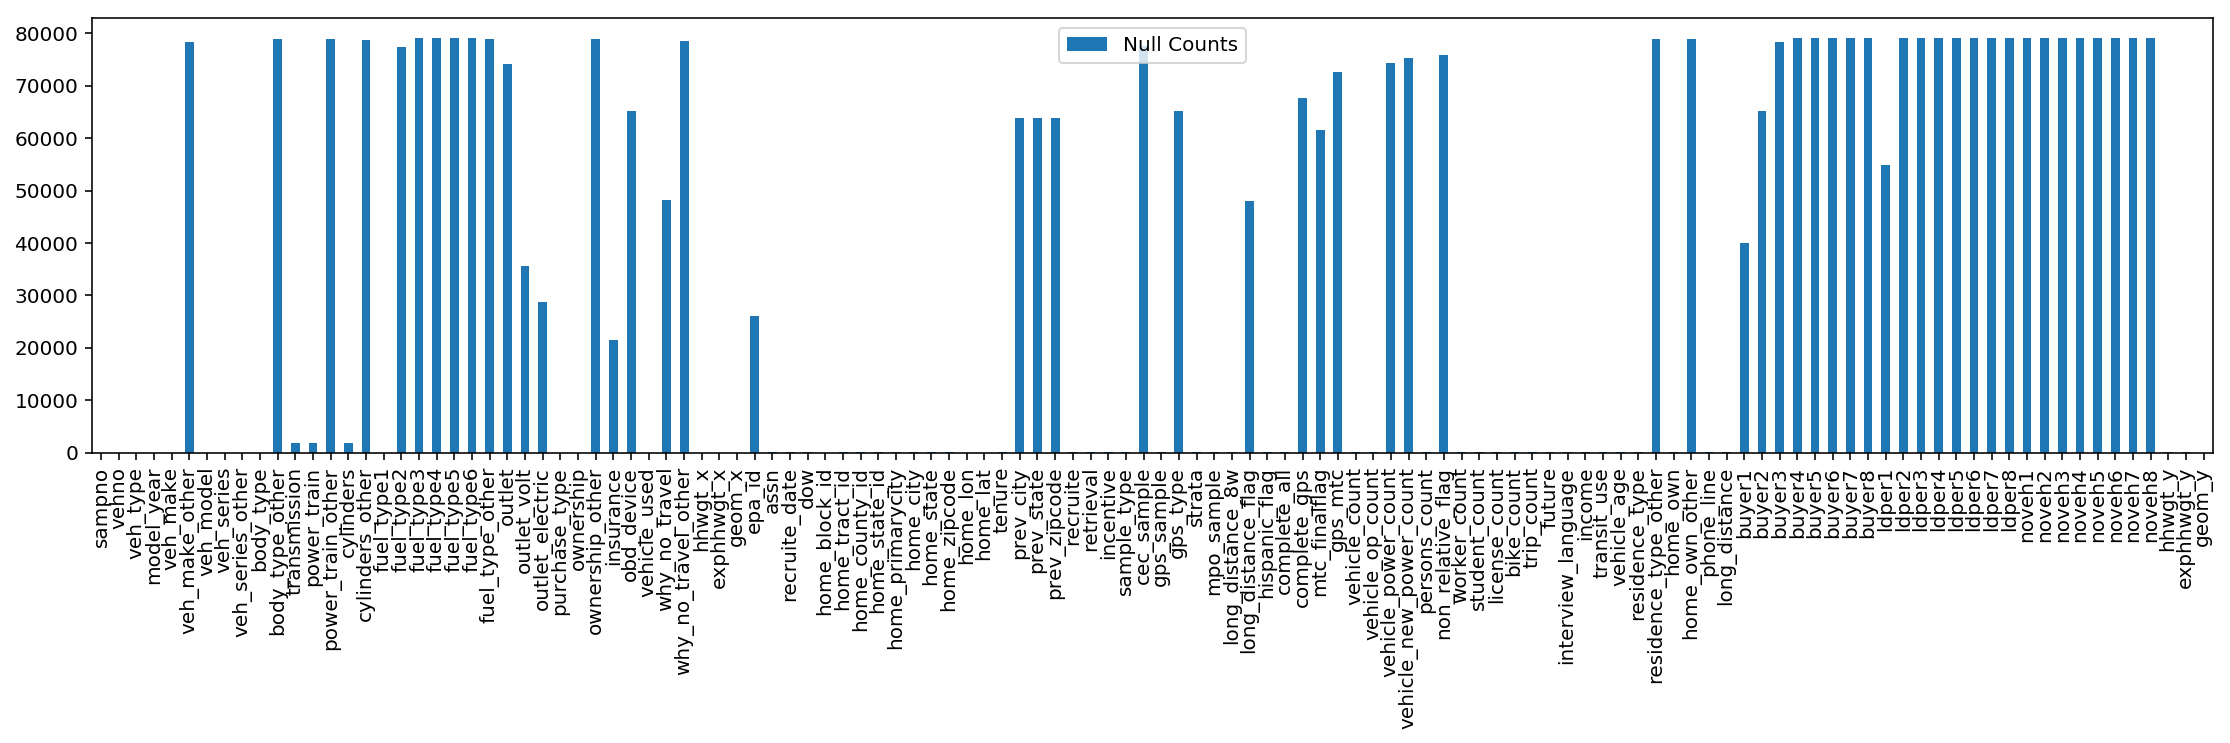

In [192]:
pd.DataFrame(df_survey_hous_veh.isnull().sum(), columns=['Null Counts']).plot(kind='bar', figsize=(19,4));

Based on the above graph, I will choose columns that don't have null values for now, and build a simple ML pipeline to predict veh_type.

In [193]:
def get_subset(df, column_names):
    ''' Return a subset of the dataframe based on the column names given.
    This will be used for quick prototyping of the entire pipeline.
    
    Parms:
        df - the original dataframe
        column_names - the column names to extract
    
    Returns:
        df_subset
    '''
    return df[column_names]

def nans_fill_zero(df):
    ''' One of many possible ways to handle any NaNs in the dataset.
    I will simply fill them with zeros.
    '''
    return df.fillna(0)

Notes, barriers: 
- Can't use home_lon or home_lat because they are 'REDACTED'.

#### Test Cases 
- Vehicle Type vs. Number of household workers and Number of household students

### Build Preprocessed Dataset
[Top](#Table-of-Contents)

In [194]:
def preprocess_data(df, column_subset=None):
    ''' Returns a preprocessed dataset. Possible preprocessing steps include:
     - getting a subset of the data
     - filling NaNs with zero, or some other value like the median of the data
     - scaling the data (z-score, etc.)
    
    Parms:
        df - the input data
        columns_subset - an optional subset of columns
    
    Returns:
        df_new - the output dataset
    '''
    df_new = df.copy()
    if column_subset:
        df_new = get_subset(df_new, column_subset)
    df_new = nans_fill_zero(df_new)
    return df_new

In [195]:
df_hous_veh_subset = preprocess_data(df_survey_hous_veh, 
                                     column_subset=['veh_type', 'worker_count', 'student_count'])

# Feature Extraction
[Top](#Table-of-Contents)

In [196]:
def expand_veh_type(df):
    ''' 
    Expanding the vehicle types into one-hot-vectors. Not really a feature, just helpful to read.
    '''
    df_new = df.copy()
    if 'veh_type' not in df.columns:
        print('Error: Vehicle type is not in the columns. Check if you dropped it already.')
        return
    
    # Create new columns based on discrete values
    veh_type_vecs = pd.get_dummies(df['veh_type'])
    
    # Add string column names
    veh_type_num_to_name = {
        1:'Hybrid', 2: 'Gasoline-only', 3:'Diesel-only',
        4:'Plug-in Hybrid Electric', 5:'CNG', 6:'Electric Only',
        7:'Other',9:'DK/RF'
    }
    column_names = [veh_type_num_to_name[num] for num in veh_type_vecs.columns]
    
    # Add these columns to the dataframe
    df_new[column_names] = veh_type_vecs
    
    # Drop the original columns
    df_new = df_new.drop('veh_type', axis=1, inplace=False)
    
    return df_new

def add_household_weight(df, df_full):
    df_new = df.copy()
    df_new['household_weight'] = df_full['hhwgt_y']
    return df_new

## Put more feature functions here...

### Build Features
[Top](#Table-of-Contents)

In [326]:
## Unused for now
def get_features(df, label):
    df_features = df.copy()
    df_features = df_features.drop(label, axis=1)
    return df_features
    
def get_labels(df, label):
    return pd.DataFrame(df[label])

def partition_data(features, labels):
    return train_test_split(features, labels, 
                           test_size=0.3,
                           random_state=789)
##

def build_features(df, df_full):
    ''' Build the final features dataframe
    
    Parms:
        df - the subsetted dataset
        df_full - the original dataset with all the columns
    Returns:
        df_features - the features dataframe
        df_target - the labels Series
    '''
    # Get and Store Labels
    df_target = df['veh_type'].copy()
    # Drop label from original df
    df = df.drop('veh_type', inplace=False, axis=1)
    
    # Get features from original dataset
    df_features = add_household_weight(df, df_full)  
    df_features = nans_fill_zero(df_features)
    
    return df_features, df_target

In [327]:
df_features, df_target = build_features(df_hous_veh_subset, df_survey_hous_veh)

In [328]:
train_features, test_features, train_labels, test_labels = train_test_split(df_features,
                                                                         df_target,
                                                                         test_size=0.3,
                                                                         random_state=789)

**Sanity check that there are no remaining null values**

In [329]:
df_features.isnull().sum()

worker_count        0
student_count       0
household_weight    0
dtype: int64

### Baseline Models
[Top](#Table-of-Contents)

In [201]:
# all_features = get_features(df, 'put_label_name_here')
# all_labels = get_labels(df, 'put_label_name_here')
# train_features, test_features, train_labels, test_labels = partition_data(all_features, all_labels)
# train_labels = np.ravel(train_labels)
# test_labels = np.ravel(test_labels)

In [330]:
def train_and_test_model(model):
    print()
    print(model)
    print()
    print('Training model...')
    fitted = model.fit(train_features, train_labels)
    print('Test the model.')
    predicted = fitted.predict(test_features)
    predicted_classes = predicted.round()
    # My Model predicted all two's
    non_gas = [x for x in predicted_classes if x !=2]
    if len(non_gas) > 0:
        print('\nPredicted some non-gasoline cars.\n')
        ## Optionally uncomment below to print the non-gas predicted cars
        #print(non_gas)
    else:
        print('\nOnly gas cars predicted. Same as baseline prediction.\n')
    accuracy = accuracy_score(predicted_classes, test_labels)
    fscore = f1_score(predicted_classes, test_labels, average='weighted')
    print('This model\'s accuracy is {}'.format(accuracy))
    print('This model\'s f1 score is {}'.format(fscore))
    return predicted, accuracy

def get_predictions_and_scores(all_models):
    '''
    Store the predictions and scores in a list of tuples, that can be sorted based on a key. The key is the
    accuracy of each model.
    
    Returns the highest score and corresponding prediction of labels.
    '''
    predictions_and_accuracies = [train_and_test_model(model) for model in all_models]
    return max(predictions_and_accuracies, key=lambda x: x[1])

In [331]:
pipeline = Pipeline([('clf', DecisionTreeClassifier())])

In [332]:
all_models = [LinearRegression(), LogisticRegression(), BernoulliNB(), pipeline]
max_score_for_prediction = get_predictions_and_scores(all_models)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Training model...
Test the model.

Only gas cars predicted. Same as baseline prediction.

This model's accuracy is 0.9197181910226122
This model's f1 score is 0.9581804197340952

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Training model...


/Users/vikram/anaconda/envs/dsji/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Test the model.

Only gas cars predicted. Same as baseline prediction.

This model's accuracy is 0.9197181910226122
This model's f1 score is 0.9581804197340952

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

Training model...
Test the model.

Only gas cars predicted. Same as baseline prediction.

This model's accuracy is 0.9197181910226122
This model's f1 score is 0.9581804197340952

Pipeline(steps=[('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])

Training model...
Test the model.

Predicted some non-gasoline cars.

This model's accuracy is 0.8938997637529531
This model's f1 score is 0.9135382149305129


/Users/vikram/anaconda/envs/dsji/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/vikram/anaconda/envs/dsji/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [333]:
print('The best model has a score of {:.2f} percent.'.format(max_score_for_prediction[1]*100))

The best model has a score of 91.97 percent.


## Change the Baseline
[Top](#Table-of-Contents)

In [334]:
df_dummy_veh_type = expand_veh_type(df_train_label)

In [335]:
df_dummy_veh_type.sum()

Hybrid                      2282
Gasoline-only              50817
Diesel-only                 1668
Plug-in Hybrid Electric       84
CNG                           55
Electric Only                187
Other                        205
DK/RF                          9
dtype: int64

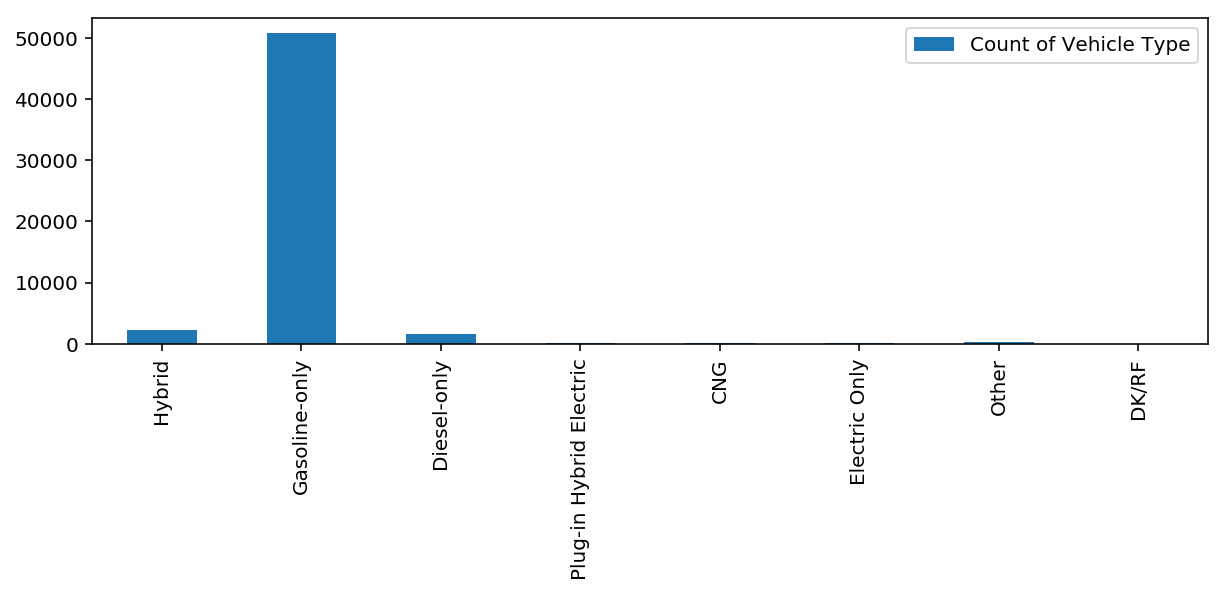

In [336]:
pd.DataFrame(df_dummy_veh_type.sum(), columns=['Count of Vehicle Type']).plot(kind='bar', figsize=(10,3));

**Predict all gasoline cars as the baseline.**

In [337]:
baseline_predictions = [2 for x in range(len(test_labels))]
print('Baseline Accuracy: {}'.format(accuracy_score(baseline_predictions, test_labels)))
print('Baseline F1-Score: {}'.format(f1_score(baseline_predictions, test_labels, average='weighted')))

Baseline Accuracy: 0.9197181910226122
Baseline F1-Score: 0.9581804197340952


/Users/vikram/anaconda/envs/dsji/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Error Analysis
[Top](#Table-of-Contents)

I will plot a confusion matrix to show how many false positives, false negatives, true positives, and true negative I classified using my model.

## Decision Trees
[Top](#Table-of-Contents)

In [301]:
def run_model(model):
    print()
    print('Training the model (Fitting to the training data) ')
    fitted = model.fit(train_features, train_labels)
    print('Fitted model: {}'.format(fitted))
    print('Test the model.')
    predicted = fitted.predict(test_features)
    predicted_classes = predicted.round()
    # My Model predicted all two's
    non_gas = [x for x in predicted_classes if x !=2]
    if len(non_gas) > 0:
        print('\nPredicted some non-gasoline cars. {}\n'.format(non_gas))
    else:
        print('\nOnly gas cars predicted. Same as baseline prediction.\n')
    accuracy = accuracy_score(predicted_classes, test_labels)
    fscore = f1_score(predicted_classes, test_labels, average='weighted')
    print('This model\'s accuracy is {}'.format(accuracy))
    print('This model\'s f1 score is {}'.format(fscore))
    return fitted

def decision_tree(leaf_nodes=10):
    return run_model(DecisionTreeClassifier(max_leaf_nodes=leaf_nodes))

In [302]:
dt_classifier = decision_tree()


Training the model (Fitting to the training data) 
Fitted model: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=10, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Test the model.

Predicted some non-gasoline cars. [3, 3, 3, 3]

This model's accuracy is 0.9195494431319609
This model's f1 score is 0.9579271577427956


/Users/vikram/anaconda/envs/dsji/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [303]:
df_features.columns

Index(['worker_count', 'student_count', 'household_weight'], dtype='object')

In [306]:
feature_names = df_features.columns
label_names = pd.DataFrame(df_target, columns=['veh_type']).columns
dot_data = export_graphviz(dt_classifier, out_file=None,
               feature_names=feature_names,
               # Below are the Vehicle Type classes
               class_names=['Hybrid','Gas-Only','Diesel-Only','Plug-in Hybrid','CNG',
                            'Electric-Only','Other','DK/RF'],
               filled=True, rounded=True,
               special_characters=False)
#graph = graphviz.Source(dot_data)
graph = pydotplus.graph_from_dot_data(dot_data)

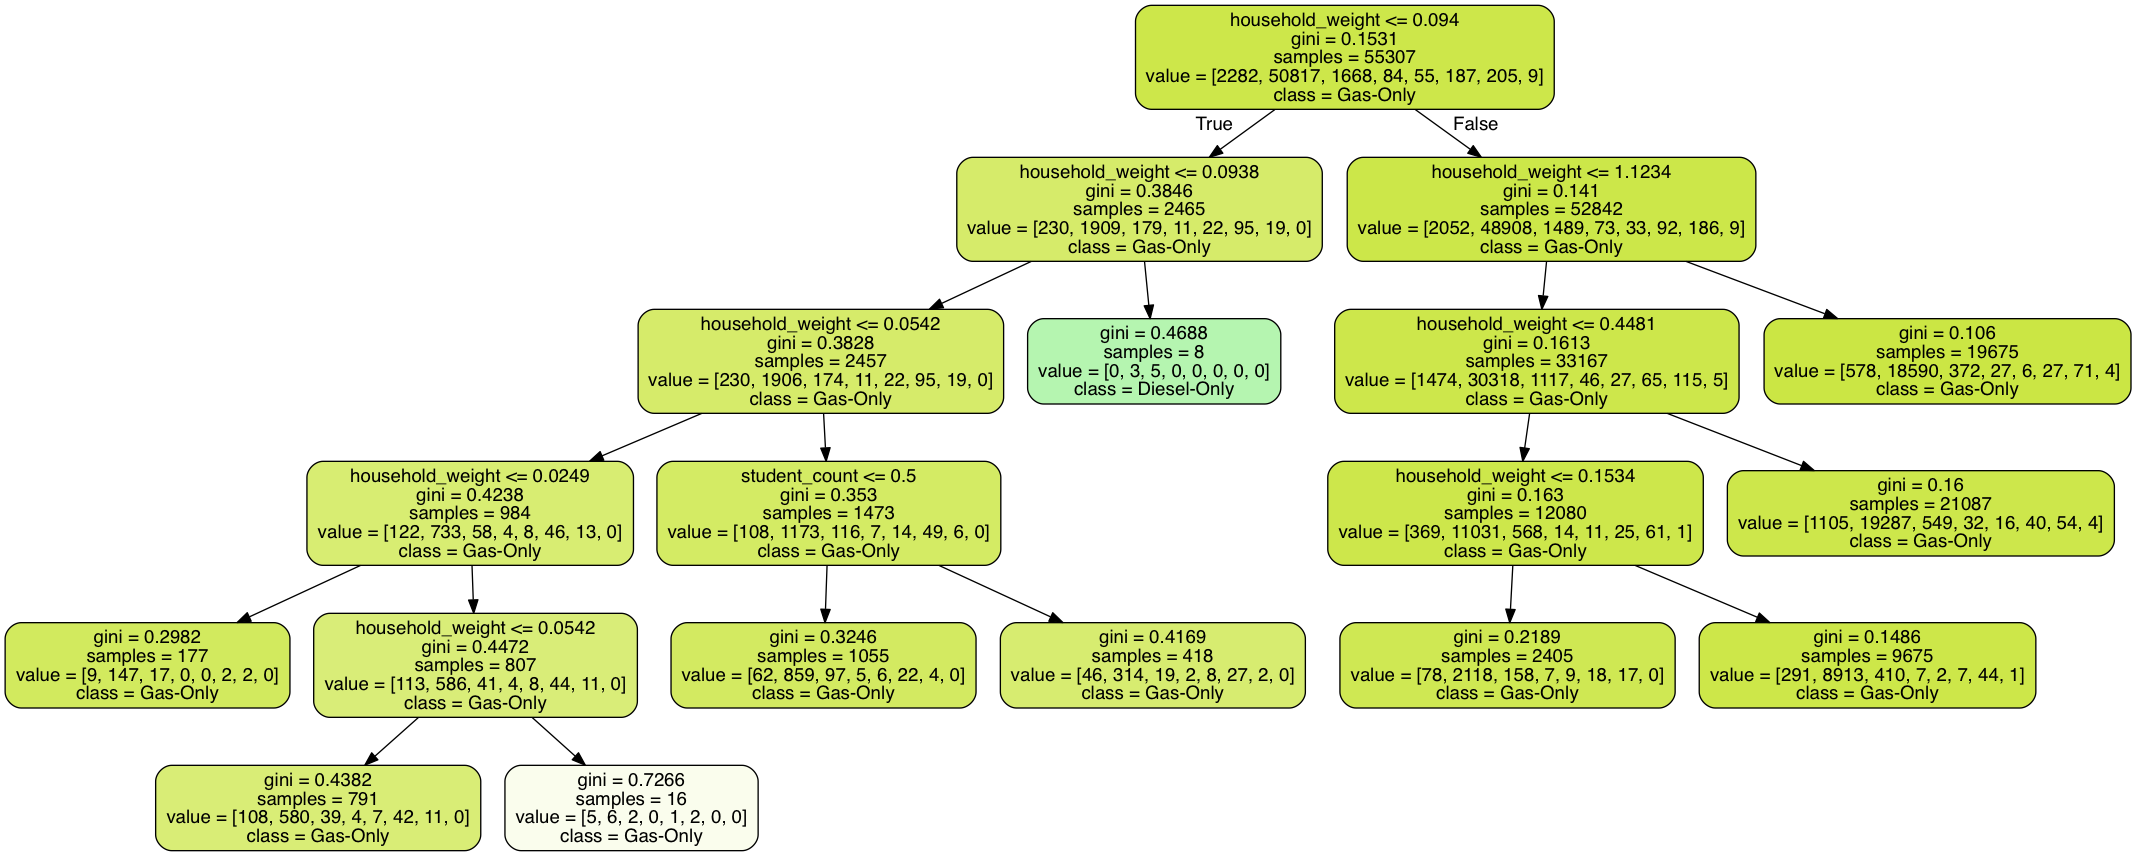

In [307]:
Image(graph.create_png())

**Random Forest**

In [308]:
run_model(RandomForestClassifier(
    n_estimators=100, max_leaf_nodes=20)
    );


Training the model (Fitting to the training data) 
Fitted model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=20,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Test the model.

Only gas cars predicted. Same as baseline prediction.

This model's accuracy is 0.9197181910226122
This model's f1 score is 0.9581804197340952


/Users/vikram/anaconda/envs/dsji/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Summary
[Top](#Table-of-Contents)